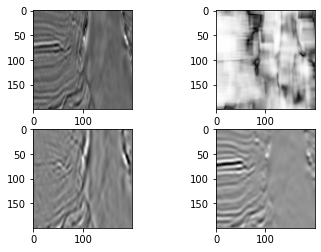

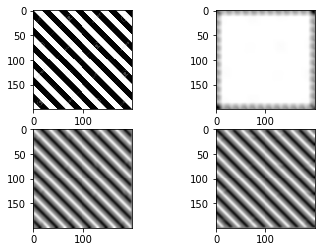

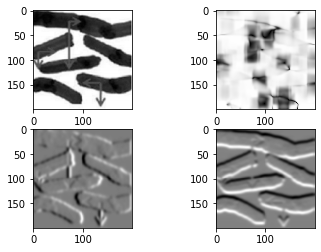

In [2]:
import os
import numpy as np
import cv2
from scipy.interpolate import RectBivariateSpline
from skimage.filters import apply_hysteresis_threshold

import matplotlib.pyplot as plt


# See PyCharm help at https://www.jetbrains.com/help/pycharm/
def show_in_plot(img1, img2, img3, img4):
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.subplot(2, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.subplot(2, 2, 3)
    plt.imshow(img3, cmap='gray')
    plt.subplot(2, 2, 4)
    plt.imshow(img4, cmap='gray')
    plt.show()

def get_patch_at(pixel_grid, i, j, size):
    x_length, y_length = pixel_grid.shape
    half_size = int(size / 2)
    start_x: int = max(0, i - half_size)
    end_x: int = min(x_length, i + half_size + 1)
    start_y: int = max(0, j - half_size)
    end_y: int = min(y_length, j + half_size + 1)
    pad_start_x: int = max(0, -(i - half_size))
    pad_end_x: int = max(0, (i + half_size + 1) - x_length)
    pad_start_y: int = max(0, -(j - half_size))
    pad_end_y: int = max(0, (j + half_size + 1) - y_length)
    pad_value = ((pad_start_x, pad_end_x), (pad_start_y, pad_end_y))
    sliced = pixel_grid[start_x:end_x, start_y:end_y]
    if pad_start_x == 0 and pad_end_x == 0 and pad_start_y == 0 and pad_end_y == 0:
        return sliced
    else:
        return np.pad(sliced, pad_value, 'edge')



def get_cov(x, y, patch_size):
    x_avg = np.average(x)
    y_avg = np.average(y)
    sum = np.multiply(x-x_avg, y-y_avg)
    return np.sum(sum) / patch_size * patch_size

def treat(img_path):
    I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    I = cv2.resize(I, dsize=(200, 200), interpolation=cv2.INTER_AREA)
    I = I / 255

    patch_size = 25
    Gx = cv2.Sobel(I, cv2.CV_64F, 1, 0, ksize=patch_size)
    Gy = cv2.Sobel(I, cv2.CV_64F, 0, 1, ksize=patch_size)

    w, h = I.shape
    patch_size = 25

    covxx = np.zeros((w, h))
    covxy = np.zeros((w, h))
    covyx = np.zeros((w, h))
    covyy = np.zeros((w, h))
    chaos=np.zeros((w, h))

    for i in range(0, w):
        for j in range(0, h):
            sovel_x_patch = get_patch_at(Gx, i, j, patch_size)
            sovel_y_patch = get_patch_at(Gy, i, j, patch_size)
            covxx[i, j] = get_cov(sovel_x_patch, sovel_x_patch, patch_size)
            covxy[i, j] = get_cov(sovel_x_patch, sovel_y_patch, patch_size)
            covyx[i, j] = get_cov(sovel_y_patch, sovel_x_patch, patch_size)
            covyy[i, j] = get_cov(sovel_y_patch, sovel_y_patch, patch_size)
            co=np.array([[covxx[i,j],covxy[i,j]],[covyx[i,j],covyy[i,j]]])
            w,_=np.linalg.eig(co)
            
            chaos[i,j]=abs(w[0]-w[1])/(w[0]+w[1])
    covxy = np.abs(covxy)
    covxy = covxy / np.max(covxy)
    # show_in_plot(covxx)
    show_in_plot(I, chaos, Gx, Gy)
    # show_in_plot(covyy)
treat("data/884cd7af00.png")
treat("sample/stripe.jpg")
treat("sample/random.png")